# exp015

level_group別モデル

In [92]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp015"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [94]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [95]:
event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

In [96]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [97]:
class Features:
    def __init__(self, sessions):
        self.sessions = sessions.copy()
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.features = sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _lg_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_event_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"lg_{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"lg_{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_elapsed_time(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["lg_elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "lg_elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_coor_mean(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"lg_room_coor_x_mean", "room_coor_y":"lg_room_coor_y_mean", "screen_coor_x":"lg_screen_coor_x_mean", "screen_coor_y":"lg_screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_cat_col_nunique(self, col):
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"lg_{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff(self):
        add_features = self.sessions.copy()
        add_features["elapsed_time_diff"] = add_features["elapsed_time"] - add_features.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"lg_elapsed_time_diff_max", "min":"lg_elapsed_time_diff_min", "mean":"lg_elapsed_time_diff_mean", "std":"lg_elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def get_features(self):
        self._lg_record_cnt()
        self._lg_event_name_record_cnt()
        self._lg_name_record_cnt()
        self._lg_elapsed_time()
        self._lg_coor_mean()
        self._lg_cat_col_nunique("text")
        self._elapsed_time_diff()
        return self.features

In [98]:
def calc_metrics():
    # oofデータを収集
    dfs = []
    for group in ["0-4", "5-12", "13-22"]:
        dfs.append(pd.read_csv(cfg.output_dir + f"{cfg.exp_name}/oof{group}.csv.gz", usecols=["question", "pred", "correct"]))

    oof = pd.concat(dfs).reset_index()

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")

In [99]:
def get_train_data(sessions, labels):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    return train

In [100]:
def prep_train_meta_features(oof):
    oof["level_group"] = oof["level_group"].astype(int)
    meta_df = oof.groupby(["session_id", "level_group"])["pred"].agg(["mean", "max", "min"]).reset_index()
    meta_df = meta_df.rename(columns={"mean":"prev_group_pred_mean", "max":"prev_group_pred_max", "min":"prev_group_pred_min"})
    meta_df["level_group"] = meta_df["level_group"] - 1
    oof = oof.merge(meta_df, on=["session_id", "level_group"], how="left")
    oof = oof.drop(columns=["pred"])
    oof["level_group"] = oof["level_group"].astype("category")
    return oof

In [101]:
def run_train(group):
    # データ読み込み
    train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
    labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
    
    train = get_train_data(train_sessions, labels)
    
    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]
    
    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{group}_{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance {group}")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance{group}.png')

    oof = pd.concat(oofs).reset_index(drop=True)
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof{group}.csv.gz", compression="gzip")

In [102]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [103]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    # modelを予め格納しておく
    models0_4 = []
    models5_12 = []
    models13_22 = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_dir = cfg.output_dir + f"{cfg.exp_name}/"
        elif mode == "kaggle_inf":
            model_dir = f"/kaggle/input/jo-wilder-{cfg.exp_name}/"
        models0_4.append(lgb.Booster(model_file=model_dir + f"{cfg.exp_name}_model0-4_{i}.lgb"))
        models5_12.append(lgb.Booster(model_file=model_dir + f"{cfg.exp_name}_model5-12_{i}.lgb"))
        models13_22.append(lgb.Booster(model_file=model_dir + f"{cfg.exp_name}_model13-22_{i}.lgb"))
    
    prev_group_pred_mean = {}
    prev_group_pred_max = {}
    prev_group_pred_min = {}
    for (sample_submission, test_sessions) in iter_test:
        level_group = test_sessions["level_group"].values[0]
        session_id = test_sessions["session_id"].values[0]
        
        if level_group == "0-4":
            models = models0_4
        elif level_group == "5-12":
            models = models5_12
        elif level_group == "13-22":
            models = models13_22

        test = get_train_data(test_sessions, sample_submission)
        
        # 一つ前のlevel_groupの予測値
        if level_group == "0-4":
            # 0-4は前の予測が存在しないのでnullを入れる
            test["prev_group_pred_mean"] = np.nan
            test["prev_group_pred_max"] = np.nan
            test["prev_group_pred_min"] = np.nan
        else:
            test["prev_group_pred_mean"] = prev_group_pred_mean[session_id]
            test["prev_group_pred_max"] = prev_group_pred_max[session_id]
            test["prev_group_pred_min"] = prev_group_pred_min[session_id]


        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        
        # 次のグループでの特徴量に使用するため結果を保存
        prev_group_pred_mean[session_id] = np.mean(preds)
        prev_group_pred_max[session_id] = np.max(preds)
        prev_group_pred_min[session_id] = np.min(preds)

        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0
[LightGBM] [Info] Number of positive: 24805, number of negative: 3464
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3612
[LightGBM] [Info] Number of data points in the train set: 28269, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.877463 -> initscore=1.968621
[LightGBM] [Info] Start training from score 1.968621
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.240124	valid_1's binary_logloss: 0.279115
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.25153	valid_1's binary_logloss: 0.278291
fold : 1
[LightGBM] [Info] Number of positive: 24766, number of negative: 3503
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 28269, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876083 -> initscore=1.955852
[LightGBM] [Info] Start training from score 1.955852
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.241741	valid_1's binary_logloss: 0.27289
[200]	training's binary_logloss: 0.213081	valid_1's binary_logloss: 0.275388
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.236519	valid_1's binary_logloss: 0.272833
fold : 2
[LightGBM] [Info] Number of positive: 24887, number of negative: 3382
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 28269, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.880364 -> initscore=1.995878
[LightGBM] [Info] Start training from score 1.995878
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.235901	valid_1's binary_logloss: 0.296328
[200]	training's binary_logloss: 0.208606	valid_1's binary_logloss: 0.298229
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.226075	valid_1's binary_logloss: 0.295818
fold : 3
[LightGBM] [Info] Number of positive: 24841, number of negative: 3428
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3625
[LightGBM] [Info] Number of data points in the train set: 28269, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.878736 -> initscore=1.980519
[LightGBM] [Info] Start training from score 1.980519
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.238139	valid_1's binary_logloss: 0.286063
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.249853	valid_1's binary_logloss: 0.285721
fold : 4
[LightGBM] [Info] Number of positive: 24849, number of negative: 3423
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3627
[LightGBM] [Info] Number of data points in the train set: 28272, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.878926 -> initscore=1.982300
[LightGBM] [Info] Start training from score 1.982300
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.237265	valid_1's binary_logloss: 0.288708
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.238793	valid_1's binary_logloss: 0.288464
fold : 0
[LightGBM] [Info] Number of positive: 61008, number of negative: 33222
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4160
[LightGBM] [Info] Number of data points in the train set: 94230, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.647437 -> initscore=0.607793
[LightGBM] [Info] Start training from score 0.607793
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.531259	valid_1's binary_logloss: 0.55253
[200]	training's binary_logloss: 0.511819	valid_1's binary_logloss: 0.552503
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.526658	valid_1's binary_logloss: 0.552055
fold : 1
[LightGBM] [Info] Number of positive: 60912, number of negative: 33318
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4177
[LightGBM] [Info] Number of data points in the train set: 94230, number of used features: 29


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646418 -> initscore=0.603332
[LightGBM] [Info] Start training from score 0.603332
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.530006	valid_1's binary_logloss: 0.557864
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.537327	valid_1's binary_logloss: 0.557565
fold : 2
[LightGBM] [Info] Number of positive: 61004, number of negative: 33226
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4193
[LightGBM] [Info] Number of data points in the train set: 94230, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.647395 -> initscore=0.607607
[LightGBM] [Info] Start training from score 0.607607
Training until validation scores don't improve for

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.528561	valid_1's binary_logloss: 0.562294
[200]	training's binary_logloss: 0.509603	valid_1's binary_logloss: 0.562695
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.52041	valid_1's binary_logloss: 0.562092
fold : 3
[LightGBM] [Info] Number of positive: 61049, number of negative: 33181
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4181
[LightGBM] [Info] Number of data points in the train set: 94230, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.647872 -> initscore=0.609699
[LightGBM] [Info] Start training from score 0.609699
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.530106	valid_1's binary_logloss: 0.556775
[200]	training's binary_logloss: 0.511138	valid_1's binary_logloss: 0.557281
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.527448	valid_1's binary_logloss: 0.556602
fold : 4
[LightGBM] [Info] Number of positive: 60835, number of negative: 33405
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4178
[LightGBM] [Info] Number of data points in the train set: 94240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.645533 -> initscore=0.599460
[LightGBM] [Info] Start training from score 0.599460
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.529978	valid_1's binary_logloss: 0.556975
[200]	training's binary_logloss: 0.511323	valid_1's binary_logloss: 0.55711
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.526521	valid_1's binary_logloss: 0.556722
fold : 0
[LightGBM] [Info] Number of positive: 33621, number of negative: 13494
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4302
[LightGBM] [Info] Number of data points in the train set: 47115, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.713594 -> initscore=0.912906
[LightGBM] [Info] Start training from score 0.912906
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.48528	valid_1's binary_logloss: 0.514365
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.491493	valid_1's binary_logloss: 0.513858
fold : 1
[LightGBM] [Info] Number of positive: 33590, number of negative: 13525
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4299
[LightGBM] [Info] Number of data points in the train set: 47115, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.712936 -> initscore=0.909689
[LightGBM] [Info] Start training from score 0.909689
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.482268	valid_1's binary_logloss: 0.522164
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.488326	valid_1's binary_logloss: 0.52183
fold : 2
[LightGBM] [Info] Number of positive: 33611, number of negative: 13504
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 47115, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.713382 -> initscore=0.911867
[LightGBM] [Info] Start training from score 0.911867
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.483901	valid_1's binary_logloss: 0.515902
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.484158	valid_1's binary_logloss: 0.515816
fold : 3
[LightGBM] [Info] Number of positive: 33586, number of negative: 13529
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4284
[LightGBM] [Info] Number of data points in the train set: 47115, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.712852 -> initscore=0.909274
[LightGBM] [Info] Start training from score 0.909274
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.484113	valid_1's binary_logloss: 0.517592
[200]	training's binary_logloss: 0.460155	valid_1's binary_logloss: 0.518722
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.480613	valid_1's binary_logloss: 0.51729
fold : 4
[LightGBM] [Info] Number of positive: 33644, number of negative: 13476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4285
[LightGBM] [Info] Number of data points in the train set: 47120, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714007 -> initscore=0.914924
[LightGBM] [Info] Start training from score 0.914924
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[100]	training's binary_logloss: 0.482716	valid_1's binary_logloss: 0.524267
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.495579	valid_1's binary_logloss: 0.523744
best_score 0.679171
best_threshold 0.630
------------------------------
Q1 : F1 = 0.570354
Q2 : F1 = 0.498309
Q3 : F1 = 0.565609
Q4 : F1 = 0.598411
Q5 : F1 = 0.320443
Q6 : F1 = 0.574733
Q7 : F1 = 0.495109
Q8 : F1 = 0.297112
Q9 : F1 = 0.501434
Q10 : F1 = 0.335492
Q11 : F1 = 0.320310
Q12 : F1 = 0.567978
Q13 : F1 = 0.421804
Q14 : F1 = 0.420020
Q15 : F1 = 0.344043
Q16 : F1 = 0.311172
Q17 : F1 = 0.307747
Q18 : F1 = 0.564911
[1 1 1]
[1 0 1 1 1]
[1 0 1 1 0 1 0 0 1 0]
[1 1 1]
[0 0 1 0 1]
[0 0 0 0 0 0 0 0 1 0]
[1 1 1]
[1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 0]


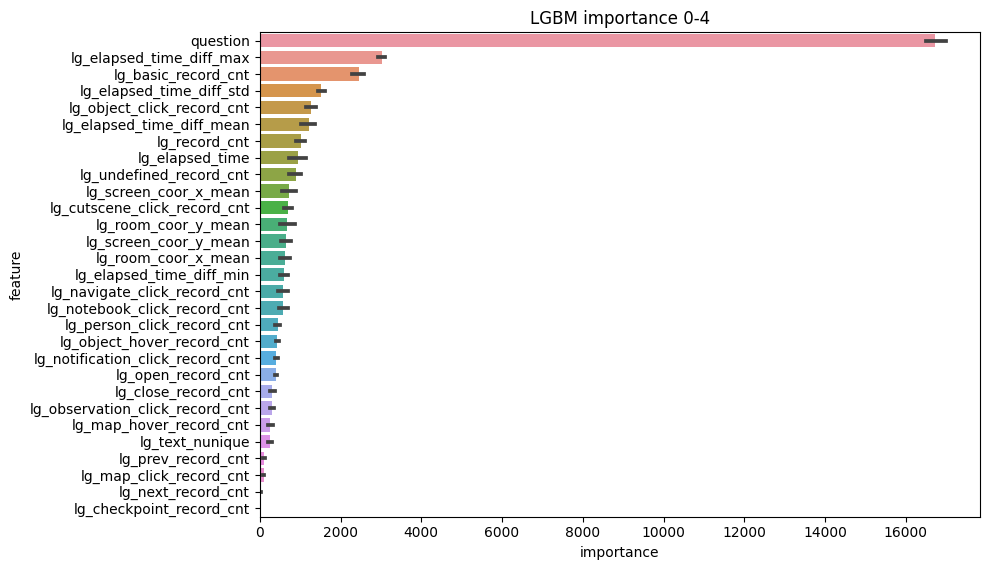

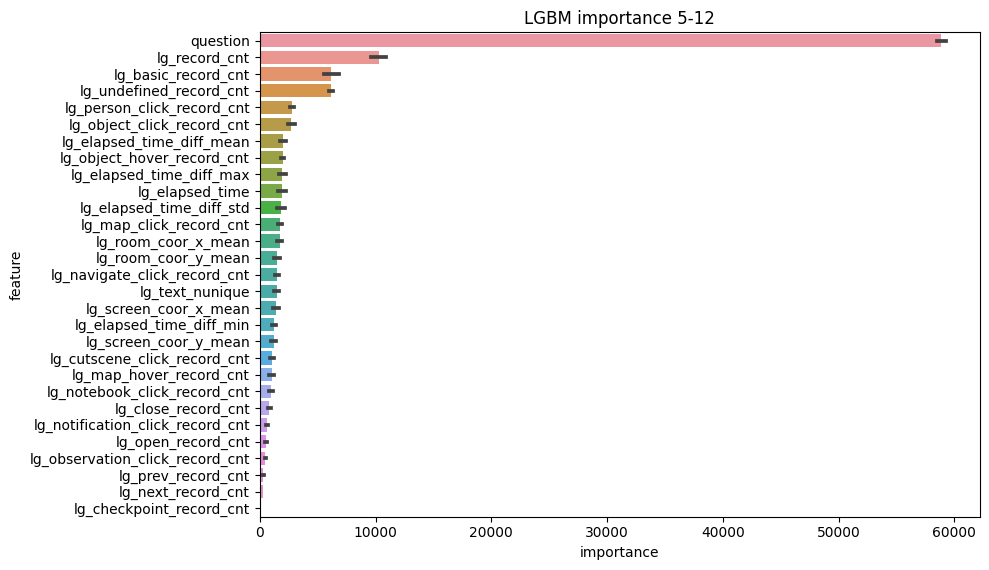

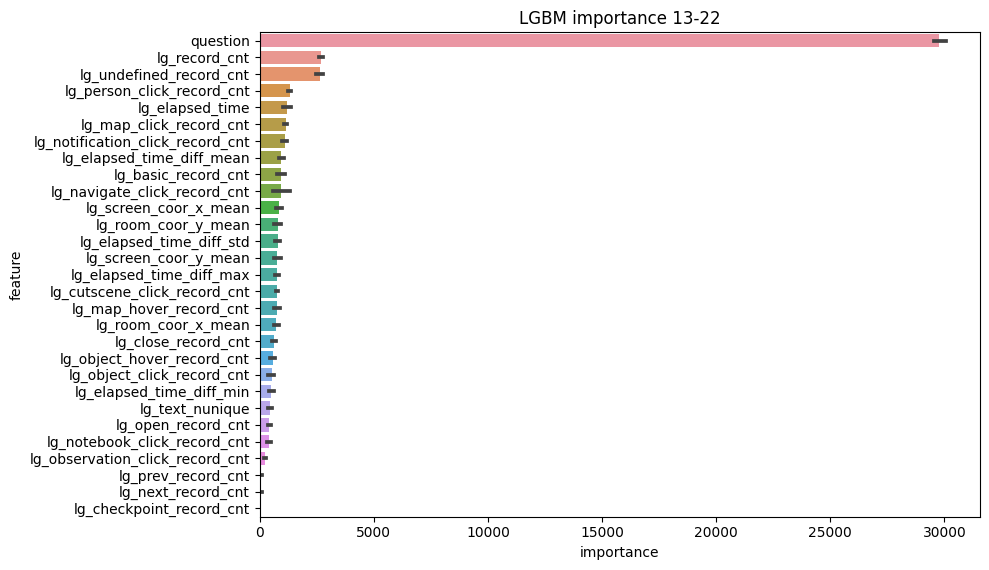

In [104]:
if cfg.mode == "local_cv":
    for group in ["0-4", "5-12", "13-22"]:
        run_train(group)
    calc_metrics()
inference(cfg.mode)